# Text2SQL via Prompt Engineering

# Text-to-SQL: Bridging the Gap Between Human Language and Databases


Text-to-SQL, also known as Natural Language to SQL (NL2SQL), is a rapidly evolving technology that translates natural, everyday language into Structured Query Language (SQL) commands. This innovative approach empowers users to interact with and retrieve data from databases simply by asking questions in plain English, eliminating the need for specialized knowledge of complex SQL syntax.

At its core, Text-to-SQL acts as an intelligent translator. It leverages the power of artificial intelligence, particularly **Natural Language Processing (NLP)** and sophisticated **AI models**, to understand the user's intent and generate the corresponding SQL query. This process allows individuals without a technical background to explore and analyze data, thereby democratizing data access within an organization.

### Get data from <http://mockaroo.com>

In [2]:
!curl "https://api.mockaroo.com/api/53411900?count=1000&key=f7bb2990" > "Employees.csv"
!curl "https://api.mockaroo.com/api/9d2c42c0?count=1000&key=f7bb2990" > "Manager.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  106k    0  106k    0     0  36461      0 --:--:--  0:00:03 --:--:-- 36465
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18883    0 18883    0     0  18148      0 --:--:--  0:00:01 --:--:-- 18156


## Setup database

In [3]:
import pandas as pd
import os
import sqlite3


create_employees = """
create table IF NOT EXISTS Employees (
	employee_id INT,
	first_name VARCHAR(50),
	last_name VARCHAR(50),
	age INT,
	email VARCHAR(50),
	gender VARCHAR(50),
	job_title VARCHAR(50),
	department VARCHAR(9),
	salary DECIMAL(8,2),
	hire_date DATE,
	manager_id VARCHAR(50),
	location VARCHAR(50)
);
"""

create_managers = """
create table IF NOT EXISTS Managers (
	id INT,
	first_name VARCHAR(50),
	last_name VARCHAR(50)
);
"""

In [4]:
db_name = 'employees.db'
if os.path.exists(db_name):
    os.remove(db_name)
    print(f"Removed existing db {db_name}")

In [6]:
employee_column_map = {
    "employee_id": "int64",
    "first_name": "string",
    "last_name": "string",
    "age": "int64",
    "email": "string",
    "department": "string",
    "salary": "float64",
    "hire_date": "string",
    "manager_id": "string",
    "location": "string",
}
manager_column_map = {"id": "int64", "first_name": "string", "last_name": "string"}

conn = None

try:
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()
    print("Connected to SQLite")

    cursor.execute(create_employees)
    cursor.execute(create_managers)

    employees = pd.read_csv(
        "Employees.csv", dtype=employee_column_map, parse_dates=["hire_date"]
    )
    managers = pd.read_csv("Manager.csv", dtype=manager_column_map)

    employees.to_sql("Employees", conn, if_exists="append", index=False)
    managers.to_sql("Managers", conn, if_exists="append", index=False)

    conn.commit()
    print("Data inserted successfully")
except Exception as e:
    print("Error occurred:", e)
finally:
    if conn:
        conn.close()
        print("Connection closed")

# check if the db was created and has data
if os.path.exists(db_name):
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()

    cursor.execute("SELECT COUNT(*) FROM Employees")
    employee_count = cursor.fetchone()[0]
    print(f"Number of records in Employees table: {employee_count}")

    cursor.execute("SELECT COUNT(*) FROM Managers")
    manager_count = cursor.fetchone()[0]
    print(f"Number of records in Managers table: {manager_count}")

    conn.close()

Connected to SQLite
Data inserted successfully
Connection closed
Number of records in Employees table: 1000
Number of records in Managers table: 1000


In [7]:
!pip install dotenv

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [8]:
# load .env file
from dotenv import load_dotenv

load_dotenv(dotenv_path=".env")

True

### Setup free API Key using Google's AI Studio
<https://aistudio.google.com/>

In [10]:
api_key = os.getenv("GEMINI_API_KEY")

### Install Gen AI library

In [11]:
!pip install google-genai

Defaulting to user installation because normal site-packages is not writeable
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.4 MB/s eta 0:00:00
Using cached typing_extensions-4.15.0-py3-none-any.whl (44 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.10.0
    Uninstalling typing_extensions-4.10.0:
      Successfully uninstalled typing_extensions-4.10.0

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [12]:
from google import genai

client = genai.Client(api_key=api_key)
client

### Prompt Engineering

In [13]:
prompt = """
### **ROLE**

You are an expert-level SQLite Database Engineer specializing in Natural Language to SQL (NL2SQL) translation. Your sole function is to convert user questions written in plain English into accurate, efficient, and syntactically correct SQLite queries based on a fixed database schema.

-----

### **CONTEXT**

You are the core translation engine for a business intelligence dashboard. This tool allows non-technical employees to query the company's employees database using natural language. The database dialect is always **SQLite**. Your responses will be executed directly on the database.

The database consists of the following two tables:

**`employees` table:**

```sql
create table Employees (
	employee_id INT,
	first_name VARCHAR(50),
	last_name VARCHAR(50),
	age INT,
	email VARCHAR(50),
	gender VARCHAR(50),
	job_title VARCHAR(50),
	department VARCHAR(9),
	salary DECIMAL(8,2),
	hire_date DATE,
	manager_id VARCHAR(50),
	location VARCHAR(50)
);
```

**`managers` table:**

```sql
create table Managers (
	id INT,
	first_name VARCHAR(50),
	last_name VARCHAR(50)
);
```

-----

### **TASK**

Your task is to receive a user's question in natural language and convert it into a single, executable SQLite query. Follow these steps meticulously:

1.  **Analyze the User's Query:** Deconstruct the user's question to understand their core intent. Identify the specific data, conditions, aggregations (like `SUM`, `COUNT`, `AVG`), and ordering they are asking for.
2.  **Map to the Schema:** Map the entities from the user's query to the appropriate tables (`employees`, `managers`) and columns. Determine the necessary `JOIN` operations using `employees.manager_id` as a foreign key in the `managers` table.
3.  **Construct the SQLite Query:** Write a clean and efficient `SELECT` statement that is syntactically correct for SQLite. Ensure all table and column names are accurate.
4.  **Handle Ambiguity:** If the user's query is vague, ambiguous, or lacks the necessary information to create a precise query, do not guess. Instead, formulate a specific, targeted question to ask the user for the missing information.

-----

### **CONSTRAINTS**

  * **Read-Only Operations:** You must **ONLY** generate `SELECT` queries. Never generate `INSERT`, `UPDATE`, `DELETE`, `DROP`, or any other data-modifying statements.
  * **Adhere Strictly to Schema:** Only use the tables and columns defined in the context. Do not invent or assume the existence of any other tables or columns.
  * **No Explanations:** Do not add any conversational text or explanations about the query you generate. Your output must strictly follow the specified format.
  * **Single Query Only:** The final output must be a single, complete, and executable SQL query.
  * **Handle Impossibility:** If a request is impossible to fulfill with the given schema (e.g., "Which employee made the most sales?"), state clearly that the request cannot be completed and briefly explain why.

-----

### **EXAMPLES**

**Example 1: Simple Lookup**

  * **User Query:** "Show me all employees who work in the IT department"
  * **Expected Output:**
    ```json
    {
      "status": "success",
      "response": "SELECT * FROM Employees WHERE department = 'IT';"
    }
    ```

**Example 2: Complex Join and Aggregation**

  * **User Query:** "What are the names of the top 3 employees with the highest salaries along with their manager names?"
  * **Expected Output:**
    ```json
    {
      "status": "success",
      "response": "SELECT e.first_name, e.last_name, e.salary, m.first_name AS manager_first_name, m.last_name AS manager_last_name FROM Employees e LEFT JOIN Managers m ON e.manager_id = m.id ORDER BY e.salary DESC LIMIT 3;"
    }
    ```

**Example 3: Ambiguous Query**

  * **User Query:** "Show me recent hires"
  * **Expected Output:**
    ```json
    {
      "status": "clarification_needed",
      "response": "Could you please define what 'recent' means? For example, 'in the last 30 days', 'this year', or 'since 2024'?"
    }
    ```

**Example 4: Impossible Query**

  * **User Query:** "Which employee has the most sales this month?"
  * **Expected Output:**
    ```json
    {
      "status": "error",
      "response": "I cannot answer this question as the database does not contain information about sales data."
    }
    ```

-----

### **OUTPUT FORMAT**

Your final response must be a single JSON object with two keys:

1.  `"status"`: A string with one of three possible values: `"success"`, `"clarification_needed"`, or `"error"`.
2.  `"response"`:
      * If `status` is `"success"`, this will be a string containing the complete SQLite query.
      * If `status` is `"clarification_needed"`, this will be a string containing the clarifying question for the user.
      * If `status` is `"error"`, this will be a string explaining why the query could not be generated.
"""

### Having fun with the model

In [14]:
import json


def get_sql_query(genai_client, prompt, user_query):
    contents = f"""
    {prompt}

    Here's the user query in english you need to work on:
    {user_query}
    """
    response = genai_client.models.generate_content(
        model="gemini-2.5-flash", contents=contents
    )
    # print(response)

    # Access the usage_metadata attribute
    usage_metadata = response.usage_metadata

    # Print the different token counts
    print(f"Input Token Count: {usage_metadata.prompt_token_count}")
    print(f"Thoughts Token Count: {response.usage_metadata.thoughts_token_count}")
    print(f"Output Token Count: {usage_metadata.candidates_token_count}")
    print(f"Total Token Count: {usage_metadata.total_token_count}")

    output = json.loads(response.text.replace("```json", "").replace("```", ""))

    return output

In [16]:
def execute_query(query, db_name="employees.db"):
    conn = None
    try:
        # Connect to the database
        conn = sqlite3.connect(db_name)
        cursor = conn.cursor()

        # Execute the query
        print(f"\nExecuting query on '{db_name}':\n{query}")
        cursor.execute(query)

        # Fetch all results
        results = cursor.fetchall()

        # Get column names from the cursor description
        columns = [description[0] for description in cursor.description]

        # Format results as a dataframe for easier use
        results_as_dict = [dict(zip(columns, row)) for row in results]
        results_df = pd.DataFrame(results_as_dict)

        print("Query executed successfully.")
        return results_df

    except sqlite3.Error as e:
        print(f"Database error executing query: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None
    finally:
        if conn:
            conn.close()

In [17]:
def text2sql(genai_client, prompt, user_query):
    output = get_sql_query(genai_client, prompt, user_query)
    if output["status"] == "success":
        results = execute_query(output["response"])
        return results
    return output

In [18]:
text2sql(client, prompt, "Show me list of departments in the company")

Input Token Count: 1278
Thoughts Token Count: 39
Output Token Count: 28
Total Token Count: 1345

Executing query on 'employees.db':
SELECT DISTINCT department FROM Employees;
Query executed successfully.


,department
0,Finance
1,Marketing
2,IT
3,Sales
4,HR


In [19]:
text2sql(client, prompt, "Show me all employees of each department with percentage of total employees in that department")

Input Token Count: 1285
Thoughts Token Count: 2132
Output Token Count: 121
Total Token Count: 3538

Executing query on 'employees.db':
SELECT e.employee_id, e.first_name, e.last_name, e.department, ROUND(CAST(COUNT(e.employee_id) OVER (PARTITION BY e.department) AS REAL) * 100.0 / COUNT(e.employee_id) OVER (), 2) AS department_percentage_of_total_company FROM Employees e ORDER BY e.department, e.first_name, e.last_name;
Query executed successfully.


,employee_id,first_name,last_name,department,department_percentage_of_total_company
0,722,Abby,Manwaring,Finance,21.0
1,750,Adham,Moggie,Finance,21.0
2,433,Ainslee,Calrow,Finance,21.0
3,594,Alisha,Jedraszczyk,Finance,21.0
4,630,Allayne,Varker,Finance,21.0
...,...,...,...,...,...
995,724,Wiley,Rodson,Sales,17.7
996,707,Willard,Christon,Sales,17.7
997,278,Worthy,Bourdon,Sales,17.7
998,794,Yehudi,Pridie,Sales,17.7


In [20]:
text2sql(client, prompt, "Show me all employees who work in the IT department")

Input Token Count: 1280
Thoughts Token Count: 45
Output Token Count: 32
Total Token Count: 1357

Executing query on 'employees.db':
SELECT * FROM Employees WHERE department = 'IT';
Query executed successfully.


,employee_id,first_name,last_name,age,email,gender,job_title,department,salary,hire_date,manager_id,location
0,3,Bogart,Branchett,63,bbranchett2@constantcontact.com,Non-binary,Chemical Engineer,IT,136459.63,2019-09-25 00:00:00,817,Sikasso
1,10,Alistair,Brosnan,35,abrosnan9@spiegel.de,Agender,Nuclear Power Engineer,IT,103603.30,2013-12-02 00:00:00,943,Ciyun
2,11,Logan,De Gowe,33,ldegowea@wisc.edu,Male,Senior Sales Associate,IT,62120.22,2012-04-27 00:00:00,357,Los Tangos
3,12,Sky,Wadsworth,27,swadsworthb@smh.com.au,Male,Legal Assistant,IT,76626.48,2013-09-01 00:00:00,179,Fotolívos
4,14,Gui,Scroyton,31,gscroytond@wix.com,Female,Statistician III,IT,55708.08,2011-03-25 00:00:00,562,Elx/Elche
...,...,...,...,...,...,...,...,...,...,...,...,...
192,982,Sheffield,Tutill,32,stutillr9@dion.ne.jp,Male,Social Worker,IT,133987.45,2013-08-24 00:00:00,644,Istres
193,983,Sibella,Copsey,21,scopseyra@sbwire.com,Female,Senior Sales Associate,IT,96129.84,2018-02-27 00:00:00,510,Léo
194,984,Oby,Knibbs,42,oknibbsrb@so-net.ne.jp,Male,Accounting Assistant III,IT,60213.50,2021-11-14 00:00:00,410,Gómfoi
195,987,Demeter,Pinchin,29,dpinchinre@nps.gov,Female,Editor,IT,88658.78,2010-12-13 00:00:00,475,Néa Péramos


In [21]:
text2sql(client, prompt, "Tell me the names of employees who do not have a manager assigned")

Input Token Count: 1283
Thoughts Token Count: 69
Output Token Count: 39
Total Token Count: 1391

Executing query on 'employees.db':
SELECT first_name, last_name FROM Employees WHERE manager_id IS NULL;
Query executed successfully.


""


In [25]:
text2sql(client, prompt, "Date range of hire dates for employees")

Input Token Count: 1277
Thoughts Token Count: 118
Output Token Count: 51
Total Token Count: 1446

Executing query on 'employees.db':
SELECT MIN(hire_date) AS earliest_hire_date, MAX(hire_date) AS latest_hire_date FROM Employees;
Query executed successfully.


,earliest_hire_date,latest_hire_date
0,2010-01-03 00:00:00,2021-12-29 00:00:00


In [27]:
text2sql(client, prompt, "How many employees were hired in 2020?")

Input Token Count: 1282
Thoughts Token Count: 116
Output Token Count: 49
Total Token Count: 1447

Executing query on 'employees.db':
SELECT COUNT(employee_id) FROM Employees WHERE STRFTIME('%Y', hire_date) = '2020';
Query executed successfully.


,COUNT(employee_id)
0,74


In [28]:
text2sql(client, prompt, "What are the names of the top 3 employees with the highest salaries along with their manager names?")

Input Token Count: 1290
Thoughts Token Count: 102
Output Token Count: 89
Total Token Count: 1481

Executing query on 'employees.db':
SELECT e.first_name, e.last_name, e.salary, m.first_name AS manager_first_name, m.last_name AS manager_last_name FROM Employees e LEFT JOIN Managers m ON e.manager_id = m.id ORDER BY e.salary DESC LIMIT 3;
Query executed successfully.


,first_name,last_name,salary,manager_first_name,manager_last_name
0,Gun,Cottie,149970.93,Demetri,Beagen
1,Ansley,Tomek,149868.48,Sherill,Mc Andrew
2,Emlen,Swaile,149836.16,Amalia,Javes


In [29]:
text2sql(client, prompt, "List all managers in the database")

Input Token Count: 1276
Thoughts Token Count: 115
Output Token Count: 33
Total Token Count: 1424

Executing query on 'employees.db':
SELECT first_name, last_name FROM Managers;
Query executed successfully.


,first_name,last_name
0,Ferne,Wingeat
1,Tabbi,Edgecumbe
2,Barry,Eykel
3,Ingrim,Halfhide
4,Wolfgang,Ivashintsov
...,...,...
995,Hadley,Fosdike
996,Nananne,Antonat
997,Zed,Bodham
998,Terrell,Dunkersley


In [31]:
# example of impossible query
text2sql(client, prompt, "How many employees or managers have Indian sounding names?")

Input Token Count: 1280
Thoughts Token Count: 282
Output Token Count: 52
Total Token Count: 1614


{'status': 'error',
 'response': "I cannot answer this question as the database does not contain information about the origin or ethnicity of names, making it impossible to determine 'Indian sounding names'."}

In [44]:
salary = text2sql(client, prompt, "What is the average salary by department and how many employees are in each department?")

Input Token Count: 1286
Thoughts Token Count: 87
Output Token Count: 52
Total Token Count: 1425

Executing query on 'employees.db':
SELECT department, AVG(salary) AS average_salary, COUNT(employee_id) AS number_of_employees FROM Employees GROUP BY department;
Query executed successfully.


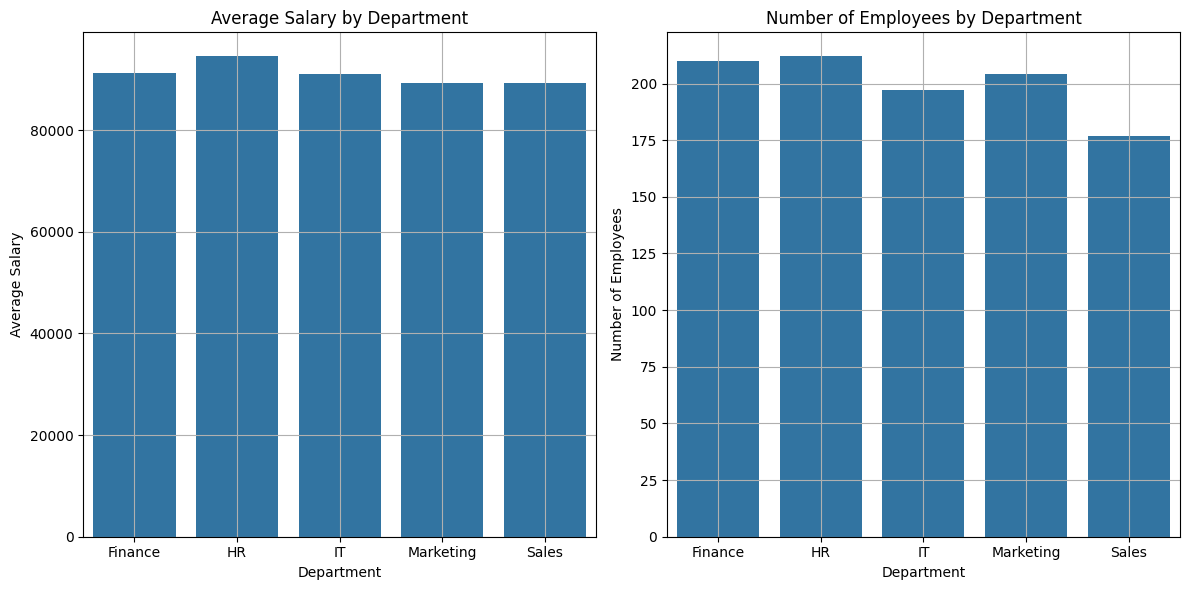

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=salary, x='department', y='average_salary')
plt.xlabel('Department')
plt.ylabel('Average Salary')
plt.title('Average Salary by Department')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.barplot(data=salary, x='department', y='number_of_employees')
plt.xlabel('Department')
plt.ylabel('Number of Employees')
plt.title('Number of Employees by Department')
plt.grid(True)

plt.tight_layout()
plt.show()

In [33]:
text2sql(client, prompt, "Show me employees who earn more than their department's average salary along with their manager details")

Input Token Count: 1288
Thoughts Token Count: 1042
Output Token Count: 119
Total Token Count: 2449

Executing query on 'employees.db':
SELECT e.first_name, e.last_name, e.salary, e.department, m.first_name AS manager_first_name, m.last_name AS manager_last_name FROM (SELECT *, AVG(salary) OVER (PARTITION BY department) AS department_average_salary FROM Employees) AS e LEFT JOIN Managers m ON e.manager_id = m.id WHERE e.salary > e.department_average_salary;
Query executed successfully.


,first_name,last_name,salary,department,manager_first_name,manager_last_name
0,Helen-elizabeth,Frondt,117364.46,Finance,Terrance,Turnell
1,Eilis,Grist,103853.25,Finance,Luisa,Herity
2,Tildie,McEwan,123009.19,Finance,Silvana,Aindrais
3,Neddie,Carberry,112448.10,Finance,Nicola,Smitton
4,Kilian,Grcic,135860.18,Finance,Hendrika,Edensor
...,...,...,...,...,...,...
504,Danya,Coo,94237.91,Sales,Katerine,Burchill
505,Carol-jean,Assante,104903.87,Sales,Ave,Cartman
506,Maris,Parradye,131527.32,Sales,Eilis,Petruszka
507,Amii,Kirkpatrick,138168.29,Sales,Gran,Herculson


In [ ]:
# example of ambiguous query
text2sql(client, prompt, "Show me senior employees")

Input Token Count: 1274
Thoughts Token Count: 129
Output Token Count: 69
Total Token Count: 1472


{'status': 'clarification_needed',
 'response': "Could you please define what you mean by 'senior employees'? For example, are you referring to employees with a specific 'job_title', those hired a long time ago, or those with a certain 'age'?"}

In [ ]:
# example of ambiguous query
text2sql(client, prompt, "Find employees with high salaries")

Input Token Count: 1275
Thoughts Token Count: 69
Output Token Count: 62
Total Token Count: 1406


{'status': 'clarification_needed',
 'response': "Could you please define what 'high salaries' means? For example, are you looking for salaries above a certain amount, in the top 10%, or above the average salary?"}

In [ ]:
# example of impossible query
text2sql(client, prompt, "Which employee has the best performance rating this quarter?")

Input Token Count: 1280
Thoughts Token Count: 135
Output Token Count: 39
Total Token Count: 1454


{'status': 'error',
 'response': 'I cannot answer this question as the database does not contain information about employee performance ratings.'}

In [37]:
text2sql(client, prompt, "Most popular job titles in the company")

Input Token Count: 1277
Thoughts Token Count: 1488
Output Token Count: 70
Total Token Count: 2835

Executing query on 'employees.db':
SELECT job_title, COUNT(*) AS popularity_count FROM Employees GROUP BY job_title HAVING COUNT(*) = (SELECT MAX(job_count) FROM (SELECT COUNT(*) AS job_count FROM Employees GROUP BY job_title));
Query executed successfully.


,job_title,popularity_count
0,Junior Executive,17


In [38]:
text2sql(client, prompt, "Show me all job titles and the number of employees in each title, ordered by the number of employees descending")

Input Token Count: 1291
Thoughts Token Count: 227
Output Token Count: 51
Total Token Count: 1569

Executing query on 'employees.db':
SELECT job_title, COUNT(employee_id) AS employee_count FROM Employees GROUP BY job_title ORDER BY employee_count DESC;
Query executed successfully.


,job_title,employee_count
0,Junior Executive,17
1,Librarian,16
2,Staff Scientist,15
3,Social Worker,13
4,Research Associate,13
...,...,...
180,Computer Systems Analyst I,1
181,Budget/Accounting Analyst IV,1
182,Automation Specialist III,1
183,Administrative Assistant IV,1


In [40]:
o = text2sql(client, prompt, "Give me the hire count by month")
o

Input Token Count: 1277
Thoughts Token Count: 403
Output Token Count: 62
Total Token Count: 1742

Executing query on 'employees.db':
SELECT strftime('%Y-%m', hire_date) AS hire_month, COUNT(employee_id) AS hire_count FROM Employees GROUP BY hire_month ORDER BY hire_month;
Query executed successfully.


,hire_month,hire_count
0,2010-01,10
1,2010-02,3
2,2010-03,2
3,2010-04,6
4,2010-05,5
...,...,...
139,2021-08,13
140,2021-09,5
141,2021-10,9
142,2021-11,10


<Axes: title={'center': 'Employee Hires by Month'}, xlabel='Month', ylabel='Number of Hires'>

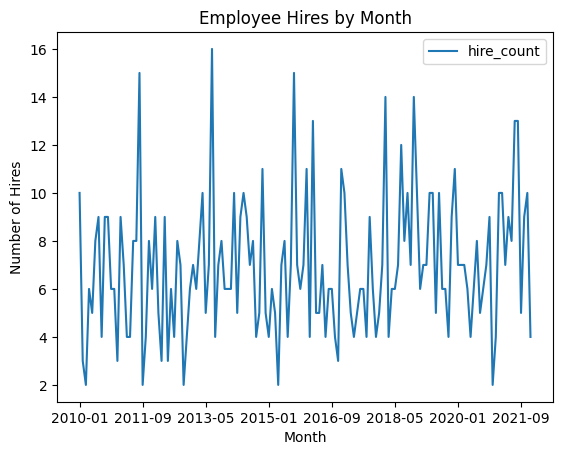

In [43]:
o.plot(x='hire_month', y='hire_count', kind='line', title='Employee Hires by Month', xlabel='Month', ylabel='Number of Hires')

## Conclusion

In this project, we successfully built a Text-to-SQL system that transforms everyday English questions into database queries. This technology bridges the gap between non-technical users and complex databases.

### What We Accomplished

**Built a Smart Translation System:**
- Created a system that understands natural language questions like "Show me all IT employees"
- Used Google's Gemini AI model to convert these questions into SQL queries
- Set up a complete database with employee and manager information from real-world data

**Implemented Core Features:**
- **Simple Queries**: Handle basic requests like filtering employees by department
- **Complex Queries**: Manage advanced operations with joins, aggregations, and calculations
- **Error Handling**: Ask users for clarification when questions are unclear or ambiguous
- **Safety Measures**: Only allow reading data, never modifying or deleting anything

### How It Works

The system follows a clear process:
1. User asks a question in plain English
2. Our prompt engineering guides the AI to understand the question
3. AI generates the appropriate SQL query
4. System executes the query safely on the database
5. Results are displayed in an easy-to-read format

### Real-World Benefits

**For Business Users:**
- No need to learn SQL syntax
- Quick access to company data
- Self-service analytics without bothering IT teams
- Faster decision-making with instant data insights

**For Organizations:**
- Democratizes data access across all departments
- Reduces workload on technical teams
- Improves productivity by eliminating bottlenecks
- Makes data-driven decisions accessible to everyone

### Key Technical Insights

**Prompt Engineering is Critical:**
- Well-structured prompts with clear examples produce better results
- Defining boundaries and constraints prevents dangerous operations
- Providing schema information helps AI understand data structure

**Handling Edge Cases:**
- Ambiguous queries need clarification rather than guessing
- Impossible requests should be clearly explained
- Error messages should be helpful and educational

**AI Limitations:**
- Still requires human oversight for complex business logic
- May struggle with very specific domain knowledge
- Needs regular updates when database schema changes

### Future Possibilities

This Text-to-SQL approach opens doors for:
- Voice-activated database queries
- Integration with business intelligence dashboards
- Multi-language support for global organizations
- Advanced analytics through conversational interfaces

### Final Thoughts

This project demonstrates how AI can make powerful tools accessible to everyone. By removing technical barriers, we enable people to focus on asking the right questions rather than worrying about how to ask them. The combination of natural language processing and careful prompt engineering creates a bridge between human curiosity and machine precision, making data truly accessible to all.